# 2D Data Preprocessing

In [1]:
import os
import glob
import pydicom
import pandas as pd

DATA_DIR = "train/"
patients = os.listdir(DATA_DIR)
train_image_files = sorted(glob.glob(os.path.join(DATA_DIR, '*','*.dcm')))

labels_df = pd.read_csv("train.csv", index_col=0)

In [2]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 80     # recommended minimum: 70
SAVE_FILE = "{}data-{}x{}.npy".format("train", IMG_SIZE, IMG_SIZE)

In [3]:
test = []
x = [[[[0,0,0],[1,2,3]],[[1,1,1],[4,5,6]]],[7,8],[9,10]]
for idx,i in enumerate(x):
    print("\nx[{}]:".format(idx), i)
    for index, j in enumerate(i):
        print("x[{}][{}]:".format(idx,index),j)
        


x[0]: [[[0, 0, 0], [1, 2, 3]], [[1, 1, 1], [4, 5, 6]]]
x[0][0]: [[0, 0, 0], [1, 2, 3]]
x[0][1]: [[1, 1, 1], [4, 5, 6]]

x[1]: [7, 8]
x[1][0]: 7
x[1][1]: 8

x[2]: [9, 10]
x[2][0]: 9
x[2][1]: 10


In [4]:
def mean(l):
    return sum(l)/len(l)

def normalize(a):
    a[a < 0] = 0
    norm = np.linalg.norm(a)
    if norm == 0:
        return a
    return a / norm


def process_data(patient, labels_df, img_px_size=70, num_slices=20):
    
    print(patient)
    path = os.path.join(DATA_DIR, patient)
    slices = [pydicom.read_file(os.path.join(path, file)) for file in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2])) # sorts images serially
    
    FVC = np.array(labels_df.at[patient, "FVC"])
    Weeks = np.array(labels_df.at[patient, "Weeks"])
    m, b = np.polyfit(Weeks, FVC, 1) # y = m*x + b; where x = Weeks, and y = FVC
    
    new_slices = []
    slopes = []
    intercepts = []
   
    for each_slice in slices:
        new_slices.append(cv2.resize(normalize(each_slice.pixel_array), (img_px_size, img_px_size)))
        slopes.append(-m)
        intercepts.append(b)

        
    '''
    Obtain slope of FVC Score as label
    Possibly check R^2 values as a counterpart to confidence score
    Check if non-linear functions describe FVC trends better than linear functions
    If so, brainstorm a numeric readout (to replace slope) from the non-linear f(x) that works best
    '''
    
   
    return np.array(new_slices), np.array(slopes), np.array(intercepts)

In [39]:
much_data = []
slopes_data = [] 
intercepts_data = []
num_key_errors = 0
num_run_errors = 0
num_attribute_errors = 0

for num, patient in enumerate(patients[:3]):
    if num%100 == 0 and num != 0:
        print(num)

    
    """
    This is a work-around for files that require GDCM to read. Try implementing get_pixeldata() method.
    """      
    try:
        img_data, slopes_data, intercepts_data = process_data(patient, 
                                                              labels_df, 
                                                              img_px_size=IMG_SIZE) 
        
        """Try a dictionary for img_data to make the dimensions the same across *_data"""
        much_data += zip(img_data, slopes_data, intercepts_data)
        
        
    except KeyError:
        print("Unlabeled data!") # error that Sentdex handled
        num_key_errors += 1
        
    except RuntimeError:
        print("GDCM required!") # error that requires GDCM dependency
        num_run_errors += 1
        
    except AttributeError:
        print("Missing ImagePositionPatient!") # use 
        num_attribute_errors += 1    
  
    
    
np.save(SAVE_FILE, much_data, allow_pickle=True)
print("Save successful!")

if num_key_errors:
    print("KeyErrors: {}".format(num_key_errors))
if num_run_errors:
    print("Runtime Errors: {}".format(num_run_errors))
if num_attribute_errors:
    print("Attribute Errors: {}".format(num_attribute_errors))

ID00007637202177411956430
ID00009637202177434476278
ID00010637202177584971671
Save successful!


In [40]:
print(much_data)

[(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 3.167125870069571, 2174.4161832946634), (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 3.167125870069571, 2174.4161832946634), (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 3.167125870069571, 2174.4161832946634), (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ...

In [42]:
np.shape(much_data[0][1])

()

In [47]:
much_data[529][2]

3311.6896077352417

In [ ]:
images = np.load(SAVE_FILE, allow_pickle=True)
images.shape, img_data.shape

In [ ]:
print(images)

TypeError: Invalid shape (0,) for image data

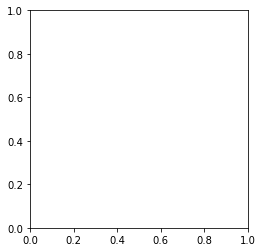

In [9]:
plt.imshow(images[0][0], cmap='gray')

In [ ]:
# import scipy.ndimage as ndimage
# from skimage import measure, morphology, segmentation
# from skimage.measure import label, regionprops
# from skimage.segmentation import clear_border
# from sklearn.cluster import KMeans

# def make_lungmask(img, display=False):
#     row_size= img.shape[0]
#     col_size = img.shape[1]
    
#     mean = np.mean(img)
#     std = np.std(img)
#     img = img-mean
#     img = img/std
    
#     # Find the average pixel value near the lungs
#     # to renormalize washed out images
#     middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
#     mean = np.mean(middle)  
#     max = np.max(img)
#     min = np.min(img)
    
#     # To improve threshold finding, I'm moving the 
#     # underflow and overflow on the pixel spectrum
#     img[img==max]=mean
#     img[img==min]=mean
    
#     # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
#     kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
#     centers = sorted(kmeans.cluster_centers_.flatten())
#     threshold = np.mean(centers)
#     thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

#     # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
#     # We don't want to accidentally clip the lung.

#     eroded = morphology.erosion(thresh_img,np.ones([3,3]))
#     dilation = morphology.dilation(eroded,np.ones([8,8]))

#     labels = measure.label(dilation) # Different labels are displayed in different colors
#     label_vals = np.unique(labels)
#     regions = measure.regionprops(labels)
#     good_labels = []
#     for prop in regions:
#         B = prop.bbox
#         if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
#             good_labels.append(prop.label)
#     mask = np.ndarray([row_size,col_size],dtype=np.int8)
#     mask[:] = 0


#     #  After just the lungs are left, we do another large dilation
#     #  in order to fill in and out the lung mask 
    
#     for N in good_labels:
#         mask = mask + np.where(labels==N,1,0)
#     mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

#     if (display):
#         fig, ax = plt.subplots(3, 2, figsize=[12, 12])
#         ax[0, 0].set_title("Original")
#         ax[0, 0].imshow(img, cmap='gray')
#         ax[0, 0].axis('off')
#         ax[0, 1].set_title("Threshold")
#         ax[0, 1].imshow(thresh_img, cmap='gray')
#         ax[0, 1].axis('off')
#         ax[1, 0].set_title("After Erosion and Dilation")
#         ax[1, 0].imshow(dilation, cmap='gray')
#         ax[1, 0].axis('off')
#         ax[1, 1].set_title("Color Labels")
#         ax[1, 1].imshow(labels)
#         ax[1, 1].axis('off')
#         ax[2, 0].set_title("Final Mask")
#         ax[2, 0].imshow(mask, cmap='gray')
#         ax[2, 0].axis('off')
#         ax[2, 1].set_title("Apply Mask on Original")
#         ax[2, 1].imshow(mask*img, cmap='gray')
#         ax[2, 1].axis('off')
        
#         plt.show()
#     return mask*img